In [53]:
import numpy as np
import torch
import torchvision
import math

import torchvision.transforms as transforms
from bgan.datasets import SynthDataset
from bgan.synth_utils import js_div, kl_div, pca
from bgan.priors import UninformativePrior, FactorizedNormalPrior
import torch.nn.functional as F

from matplotlib import pyplot as plt
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Dataset

In [54]:
img_size = 32
transform = transforms.Compose(
    [transforms.Scale(img_size),
     transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=50,
                                          shuffle=True, num_workers=2)

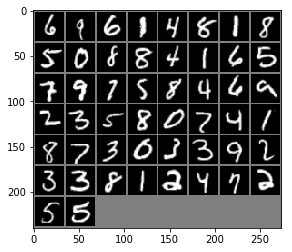

  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-33:
Process Process-34:
Traceback (most recent call last):
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
Traceback (most recent call last):
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/process.py", line 252, in _bootstrap
    self.run()
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/site-packages/torch/utils/data/dataloader.py", line 34, in _worker_loop
    r = index_queue.get()
KeyboardInterrupt
  File "/home/pi49/.conda/envs/bgan_pytorch/lib/python3.5/multiprocessing/queues.py", line 334, in get
    with self._rlock:
  File "/home/pi49/.conda/envs/bgan_pytor

In [55]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

## BGAN

In [56]:
import torch.nn as nn
import torch.optim as optim
from torch.autograd import Variable

In [57]:
trainset[0][0].size()

torch.Size([1, 32, 32])

In [77]:
def weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()
        
def gen_weight_init(m):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(0.0, 0.02)
        m.bias.data.zero_()
        
        
class GeneratorNetwork(nn.Module):
    # initializers
    def __init__(self, d=128, z_dim=100):
        super(GeneratorNetwork, self).__init__()
        self.init_net(d, z_dim)
        self.input_dim = z_dim
        
    def init_net(self, d, z_dim):
        self.deconv1 = nn.ConvTranspose2d(z_dim, d*4, 4, 1, 0)
        self.deconv1_bn = nn.BatchNorm2d(d*4)
        self.deconv2 = nn.ConvTranspose2d(d*4, d*2, 4, 2, 1)
        self.deconv2_bn = nn.BatchNorm2d(d*2)
        self.deconv3 = nn.ConvTranspose2d(d*2, d, 4, 2, 1)
        self.deconv3_bn = nn.BatchNorm2d(d)
        self.deconv4 = nn.ConvTranspose2d(d, 1, 4, 2, 1)

    # forward method
    def forward(self, x):
        x = x.view((-1, self.input_dim, 1, 1))
        x = F.relu(self.deconv1_bn(self.deconv1(x)))
        x = F.relu(self.deconv2_bn(self.deconv2(x)))
        x = F.relu(self.deconv3_bn(self.deconv3(x)))
        x = F.tanh(self.deconv4(x))

        return x
    

class DiscriminatorNetwork(nn.Module):
    
    def __init__(self, d=128):
        super(DiscriminatorNetwork, self).__init__()
        self.init_net(d)
    
    # initializers
    def init_net(self, d):
        self.conv1 = nn.Conv2d(1, d, 4, 2, 1)
        self.conv2 = nn.Conv2d(d, d*2, 4, 2, 1)
        self.conv2_bn = nn.BatchNorm2d(d*2)
        self.conv3 = nn.Conv2d(d*2, d*4, 4, 2, 1)
        self.conv3_bn = nn.BatchNorm2d(d*4)
        self.conv4 = nn.Conv2d(d*4, 1, 4, 1, 0)

    # forward method
    def forward(self, input):
        x = F.leaky_relu(self.conv1(input), 0.2)
        x = F.leaky_relu(self.conv2_bn(self.conv2(x)), 0.2)
        x = F.leaky_relu(self.conv3_bn(self.conv3(x)), 0.2)
        x = self.conv4(x)
        x = x.squeeze()

        return x


In [78]:
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()

z = Variable(torch.from_numpy(np.random.rand(10, 100)).float())
print(gen.forward(z).size())
print(disc(gen.forward(z)).size())


torch.Size([10, 1, 32, 32])
torch.Size([10])


In [79]:
from bgan.bgan_wasserstein import WBGAN

In [124]:
batch_size = 50
z_dim = 100

In [262]:
# prior = UninformativePrior()
prior = FactorizedNormalPrior(std=10.)
gen = GeneratorNetwork()
disc = DiscriminatorNetwork()
# gen.apply(weight_init)
gen.apply(gen_weight_init)
disc.apply(weight_init)
bgan = WBGAN(gen, disc, prior, alpha=.9, eta=5e-5, disc_lr = 5e-5, gen_observed=20000, MAP=False, cuda=True)
samples = []

Moving generator and discriminator to GPU
TODO: Weight Clipping constants?
TODO: RMSProp?


In [263]:
for param in gen.parameters():
    print(param.size(), np.linalg.norm(param.cpu().data.numpy()))

torch.Size([100, 512, 4, 4]) 18.1053
torch.Size([512]) 0.0
torch.Size([512]) 13.0431
torch.Size([512]) 0.0
torch.Size([512, 256, 4, 4]) 28.9481
torch.Size([256]) 0.0
torch.Size([256]) 9.09291
torch.Size([256]) 0.0
torch.Size([256, 128, 4, 4]) 14.4662
torch.Size([128]) 0.0
torch.Size([128]) 6.15005
torch.Size([128]) 0.0
torch.Size([128, 1, 4, 4]) 0.924875
torch.Size([1]) 0.0


## Training

In [264]:
num_samples = 10

In [336]:
if isinstance(samples, np.ndarray):
    samples = [samples]
    
for epoch in range(30):
    for i, data_ in enumerate(trainloader, 0):
        batch = data_[0].float()
        bgan.d_step(batch)
        if not (i%5):
            bgan.g_step(batch)
    if not epoch%1:
        batchv = Variable(batch)
        d_loss, g_loss = bgan.loss(batchv.cuda())
        print('\t', d_loss.cpu().data.numpy()[0], g_loss.cpu().data.numpy()[0])
    if not epoch%1:
        print(epoch)
    if not epoch%1:
        samples.append(bgan.sample(num_samples).cpu().data.numpy())
samples = np.vstack(samples)

	 -569897.0 278725.0
0
	 -583883.0 281463.0
1
	 -573824.0 273003.0
2
	 -620873.0 303060.0
3
	 -587454.0 272343.0
4
	 -669130.0 327719.0
5
	 -620534.0 300880.0
6
	 -670398.0 324063.0
7
	 -673050.0 325493.0
8
	 -662936.0 323341.0
9
	 -680060.0 329474.0
10
	 -746047.0 366516.0
11
	 -689141.0 325336.0
12
	 -704526.0 336877.0
13
	 -776565.0 382234.0
14
	 -789067.0 385850.0
15
	 -751209.0 368027.0
16
	 -822816.0 403001.0
17
	 -814311.0 396527.0
18
	 -855395.0 419581.0
19
	 -864828.0 424656.0
20
	 -823486.0 413878.0
21
	 -834990.0 403219.0
22
	 -905958.0 444566.0
23
	 -929304.0 456319.0
24
	 -942828.0 463318.0
25
	 -958467.0 470701.0
26
	 -973858.0 477975.0
27
	 -988040.0 484546.0
28
	 -1.00258e+06 492298.0
29


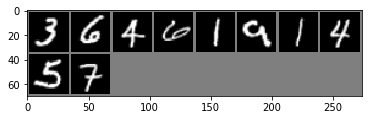

In [337]:
imshow(torchvision.utils.make_grid(batch[:10]))

In [338]:
# samples_arr = np.array(samples[:-2])
# samples_ = samples[-2:]
# samples = [samples_arr]
# samples.append(samples_[0])
# samples.append(samples_[1])
# samples = np.vstack(samples)

In [339]:
# samples = bgan.sample(100).cpu().data.numpy()

In [340]:
# samples_arr = np.vstack(samples)
samples_arr = samples

In [341]:
samples_arr.shape

(1300, 1, 32, 32)

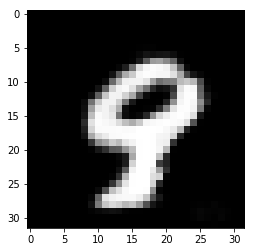

In [342]:
plt.imshow((samples_arr[-1, 0] + 1)/2, cmap='gray')

In [343]:
np.max(batch.numpy())

1.0

In [344]:
samples_arr.shape

(1300, 1, 32, 32)

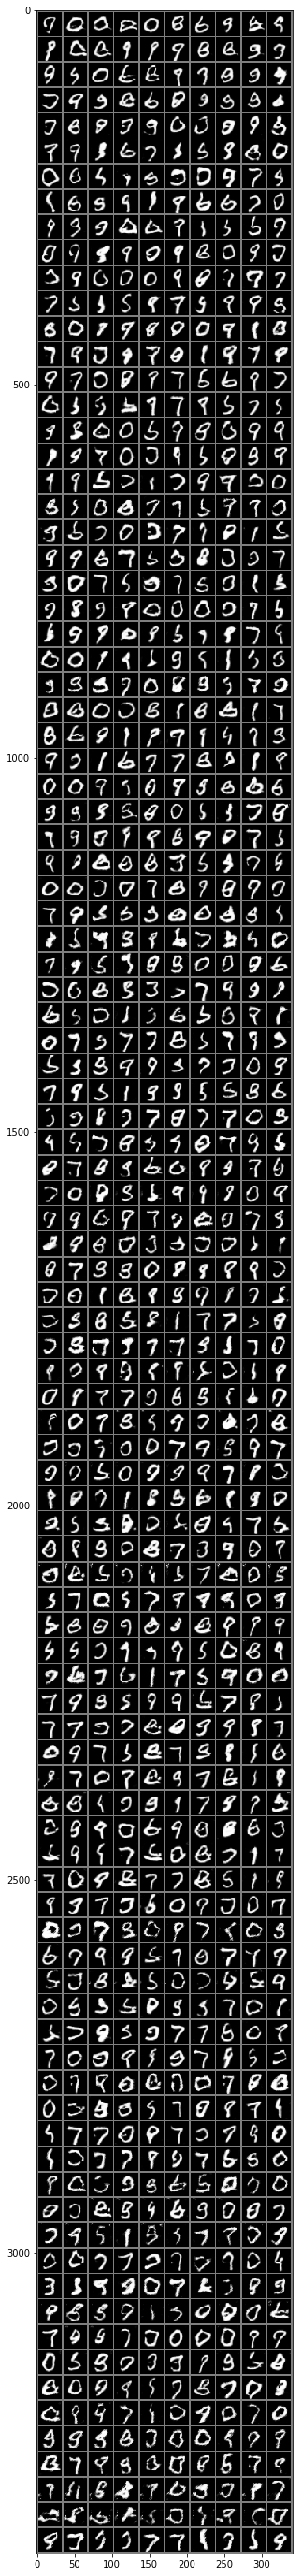

In [345]:
plt.figure(figsize=(20, 50))
show_epochs = [20, 30]
start, finish = show_epochs[0] * num_samples, (show_epochs[1]+1) * num_samples
# imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[start:finish]), nrow=30))
imshow(torchvision.utils.make_grid(torch.from_numpy(samples_arr[-1000:]), nrow=10))
